# Product Sales Forecasting using Quantitative Methods

This is a sales forecasting project for the courses CSPE14 - Data Warehousing and Data Mining and CSPE24 - AI and Expert Systems.

<b>Goal:</b> The goal of this project was to apply various quantitative methods, (i.e. Times Series Models and Causal Models) to forecast the sales of the products available in the dataset obtained from Kaggle. 

<b> Models covered in the notebook include: </b> <br>
1. Seasonal Naive Model
2. Holt-Winters Model (Triple Exponential Smoothing)
3. ARIMA and Seasonal ARIMA Models
4. Linear Regression Model

## IMPORTING THE REQUIRED LIBRARIES

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

### Load Dataset

The dataset contanins historical sales records of 10 stores and 50 products, from the year 2013 through 2017. 

In [2]:
df = pd.read_csv('data/train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


## Missing Data

No Missing Data was found for this dataset

In [3]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### Data Preprocessing
For the purpose of this project, we will only look at the sales of 'item' - 1 from 'store' - 1. The dataset is split into train and test sets, where the train set contains sales record from January 2013 to September 2017 and the test set (validation set) contains sales records of the last three month of 2017.

Some new features have been created from the date field, for the purpose of exploratory data analysis and causal modelling.

In [4]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datetime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)                         
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

print(train_df.size)

train_df.head()

13872


,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [5]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,21,2017,10,1,6
1,2017-10-02,1,1,12,2017,10,2,7
2,2017-10-03,1,1,18,2017,10,3,1
3,2017-10-04,1,1,15,2017,10,4,2
4,2017-10-05,1,1,20,2017,10,5,3


### Data Exploration
The plots below try to capture the trend and distribution of sales through weeks, months and years.

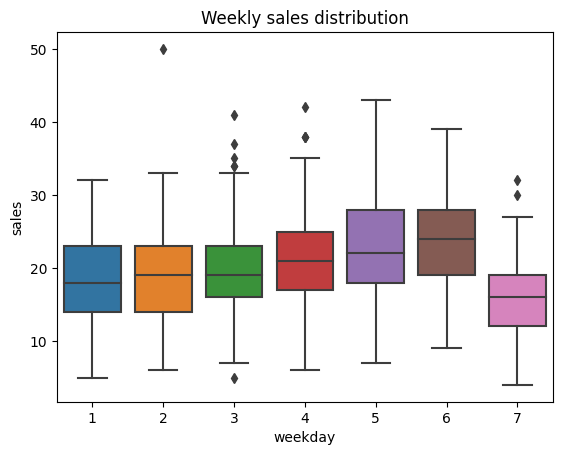

In [6]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

### Inference

The average number of sales increases over the week, is maximum on Saturday (6), and takes a sharp fall on Sunday (7)

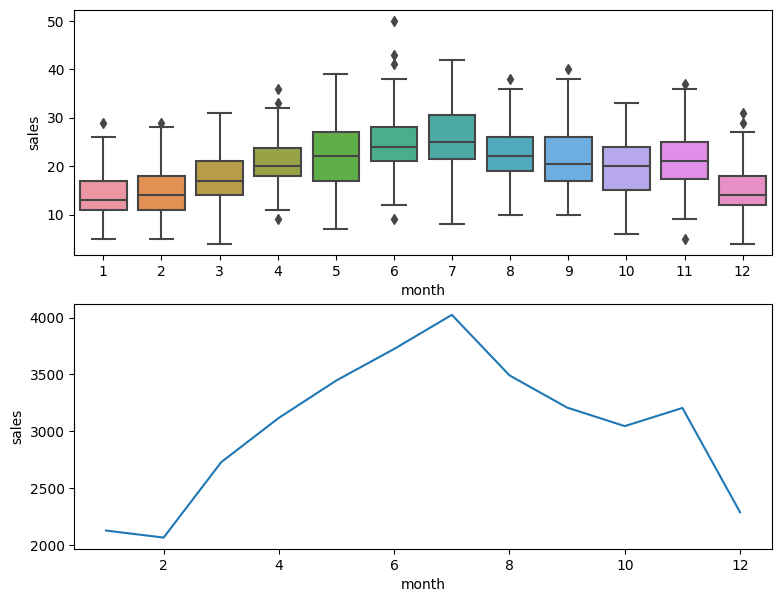

In [7]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

### Inference:
The number of sales gradually ascends in the first half of the year starting February (2), peaks in July (7), and then gradually descends, before slightly increasing in November (11) and then dropping again in December (12).

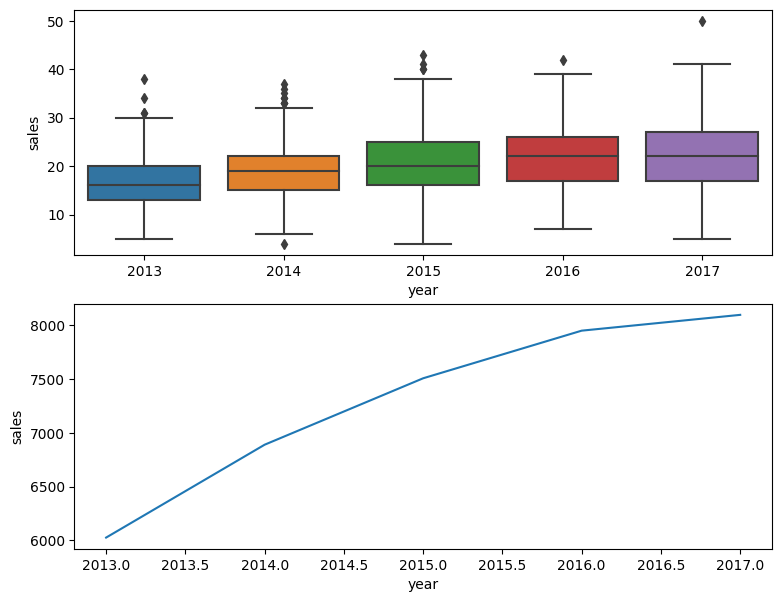

In [8]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

### Inference:

From the number of sales vs. year plot, we can infer an increasing trend over the years. The aggregate number of sales has increased from approximately 6000 in 2013 to slightly over 8000 in 2017, i.e. a <b>33.3% increase in the number of sales</b> approximately. A clear trend is captured by the lineplot above. 

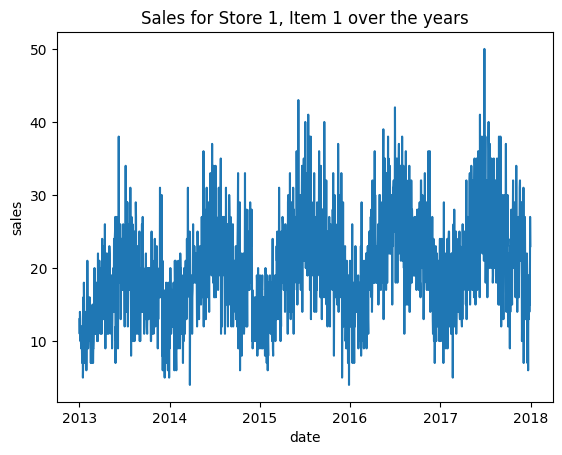

In [9]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

### Inference:
There is a seasonal pattern in the number of sales of 'item' - 1 at 'store' - 1. As also infered in the plot for sales vs. month above, we can see an increase in the sales in the first half of the year, peaking in July, and then a gradual decrease till December. This pattern is repeated each year, 2013 onwards.

### 1. Seasonal Naive (Baseline Model)

In [10]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales'] 

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,date,store,item,year,month,day,weekday,seasonal_naive_sales
0,2017-10-01,1,1,2017,10,1,6,25
1,2017-10-02,1,1,2017,10,2,7,26
2,2017-10-03,1,1,2017,10,3,1,20
3,2017-10-04,1,1,2017,10,4,2,28
4,2017-10-05,1,1,2017,10,5,3,17


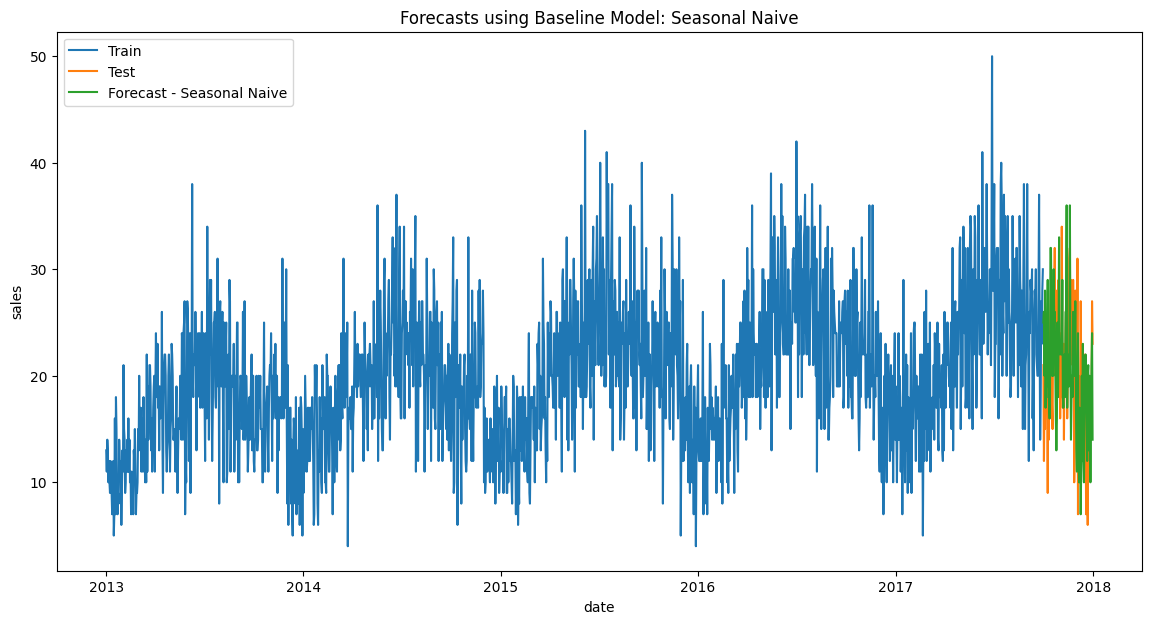

In [11]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

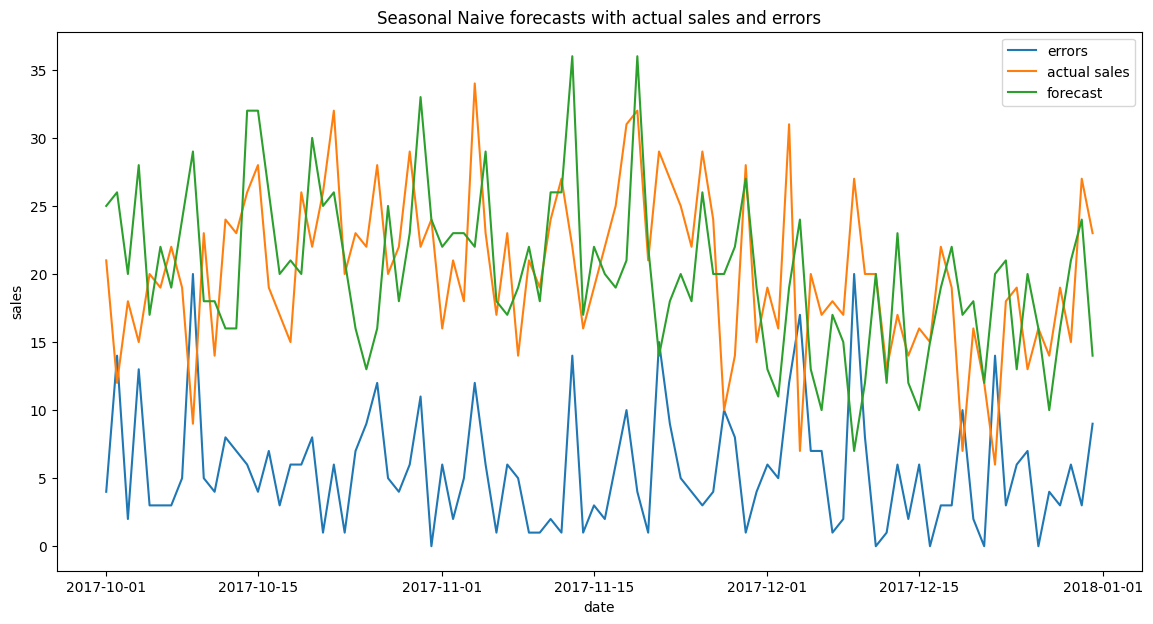

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1861,1857,4,5.630435,7.130766,27.834498


In [12]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive') 

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae), 
                                           RMSE=('errors', rmse), 
                                           MAPE=('errors', mape))
    

plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

#### Seasonal Naive Results

The model forecasts a decreasing trend. 

The Seasonal Naive Model has a <b>MAPE of 27.83%</b>

### Time Series Decomposition

By observing the seasonality, trend, and error/remainder of the data  we can decide which type of Exponential Smoothing Model to use for our forecasts.

In [13]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 640x480 with 0 Axes>

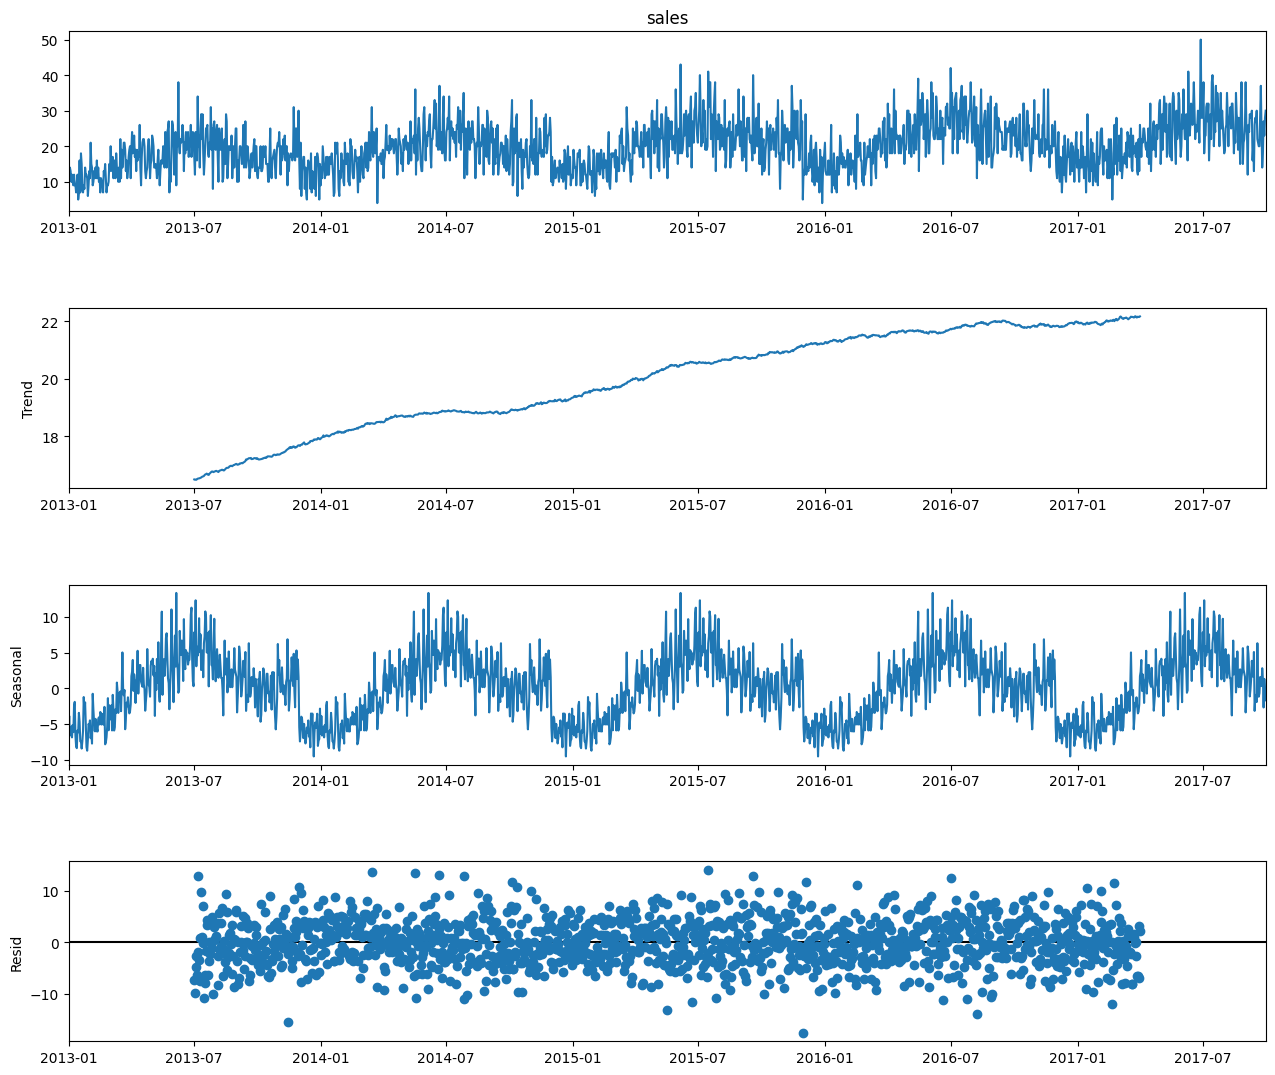

In [14]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', freq=365)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(14, 12)

#### Time Series Inference

The generated data has trend component and seasonality component as well. It suggests us to use Triple Exponential Smoothing like  Holt-Winters model.

### 2. Holt Winter's Triple Exponential Smoothing Model

In [15]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(use_boxcox=False, remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
hw_fit_2 = hw_model_2.fit(use_boxcox=False, remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_sales').reset_index()
print('Forecasts made, ready for evaluation')

/mnt/c/Users/anand/My Files/NITT/Sem6/DWDM/product-sales-forecasting-master/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/mnt/c/Users/anand/My Files/NITT/Sem6/DWDM/product-sales-forecasting-master/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


Forecasts made, ready for evaluation


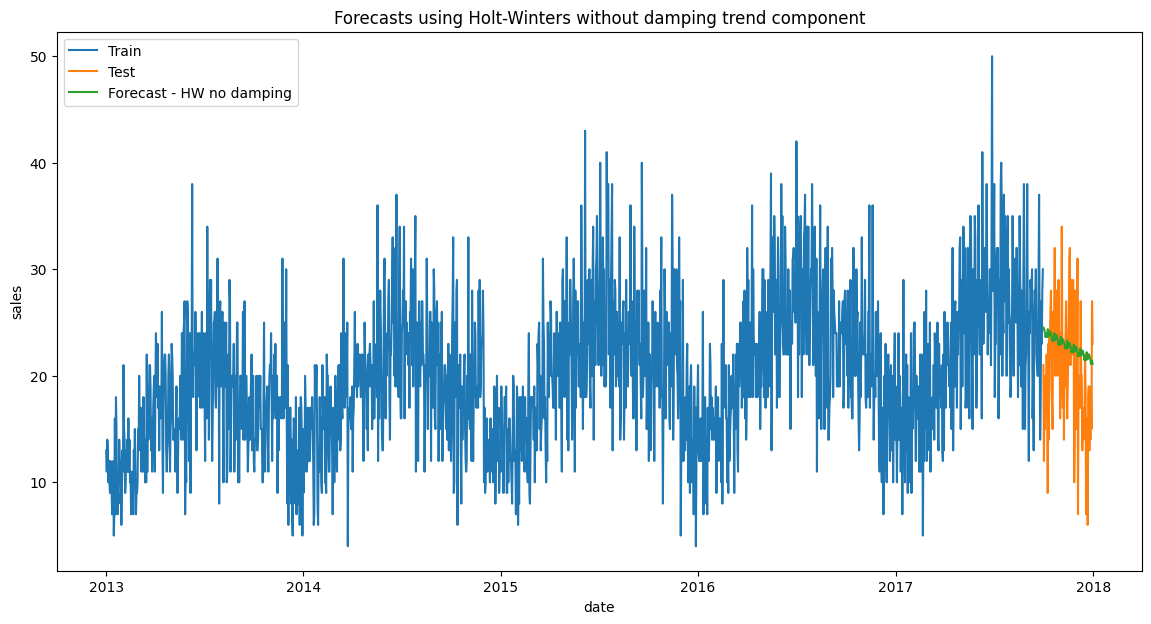

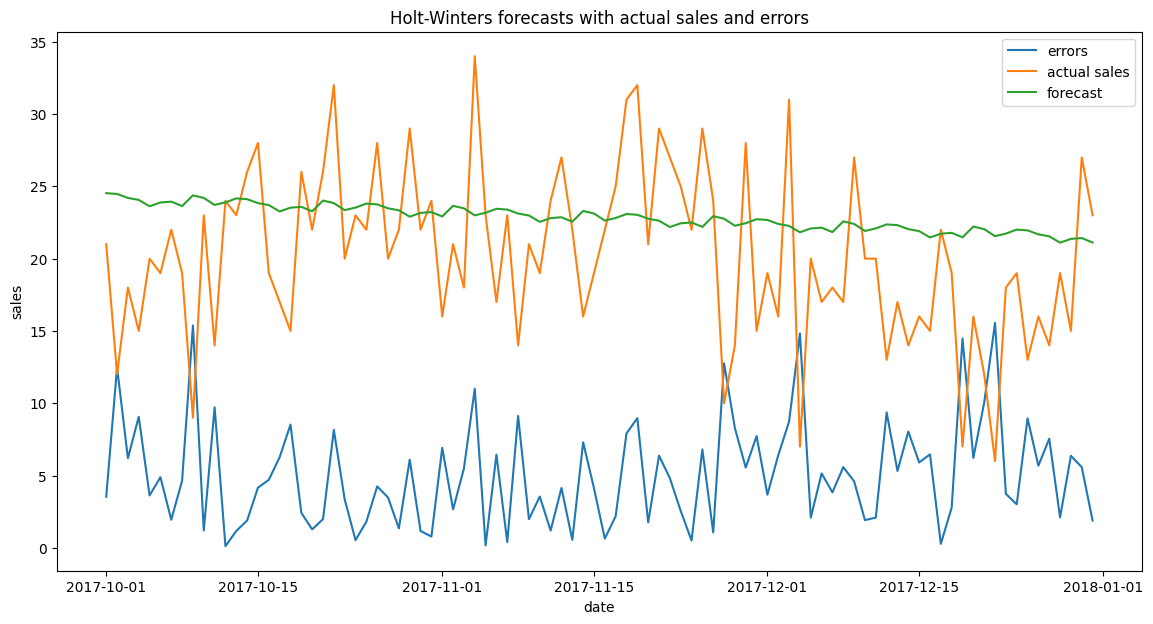

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,1861,2101.217736,-240.217736,5.077946,6.268688,25.103225


In [16]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hw

#### Holt Winters Result

The decreasing trend is clearly captured by the Holt-Winters method, and the <b>MAPE 25.10%</b> is better in comparision to our baseline model. 
 
Now let us try Holt Winters Damped model and see if there is an improvement

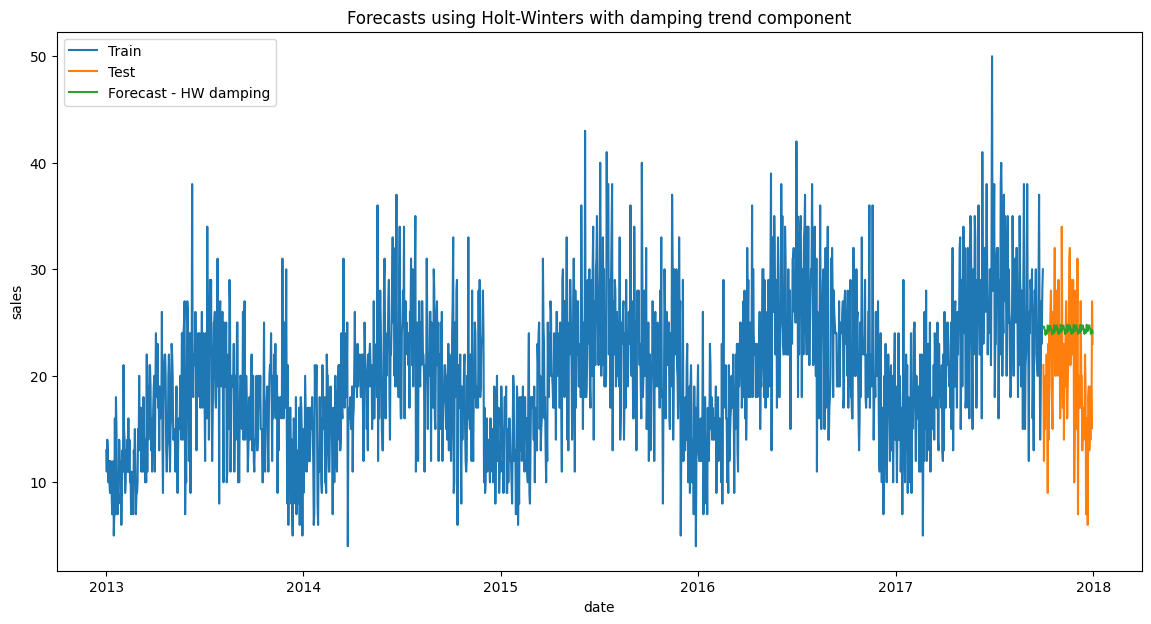

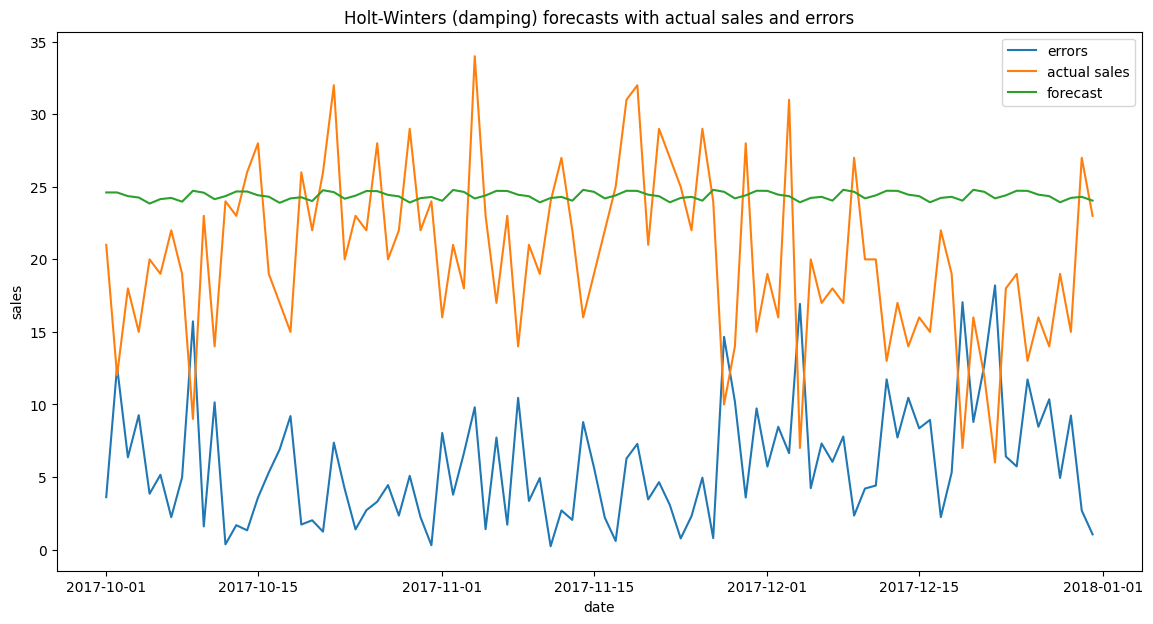

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,1861,2243.151845,-382.151845,5.870351,7.153168,29.020544


In [17]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped') 


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hwd

#### Holt Winters Damped Result

The <b>MAPE 29.02%</b> is worse than our baseline model.

### 3. Autoregressive Integrated Moving Average - ARIMA Model

#### Checking Stationarity
1. Rolling Statistics (Mean and SD)
2. Augmented Dickey-Fuller Test
3. Autocorrelation Plots (ACF - autocorrelation and PACF - partial autocorrelation)



Rolling Statistics:


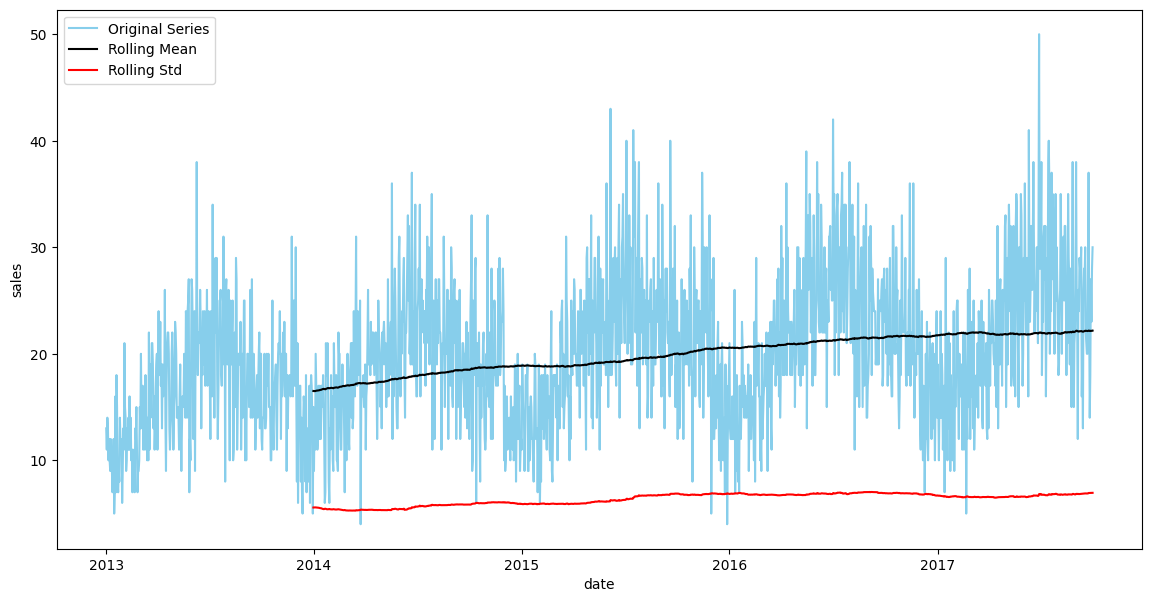



Augmented Dickey-Fuller Test:

Test statistic = -2.937
P-value = 0.041
Critical values :
	1%: -3.434179908502461 - The data is not stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


Autocorrelation Plots:


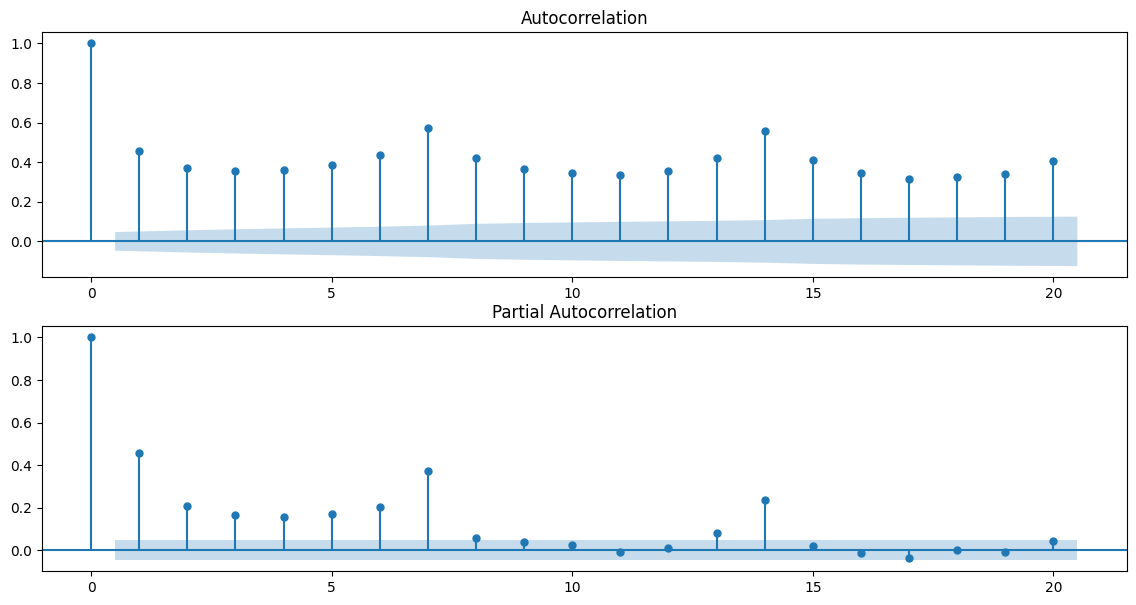

In [18]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    print("\n\nRolling Statistics:")
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    print("\n\nAugmented Dickey-Fuller Test:\n")
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    print("\n\nAutocorrelation Plots:")
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.sales)

#### Differencing
Applying Differencing (first order) to make series stationary



Rolling Statistics:


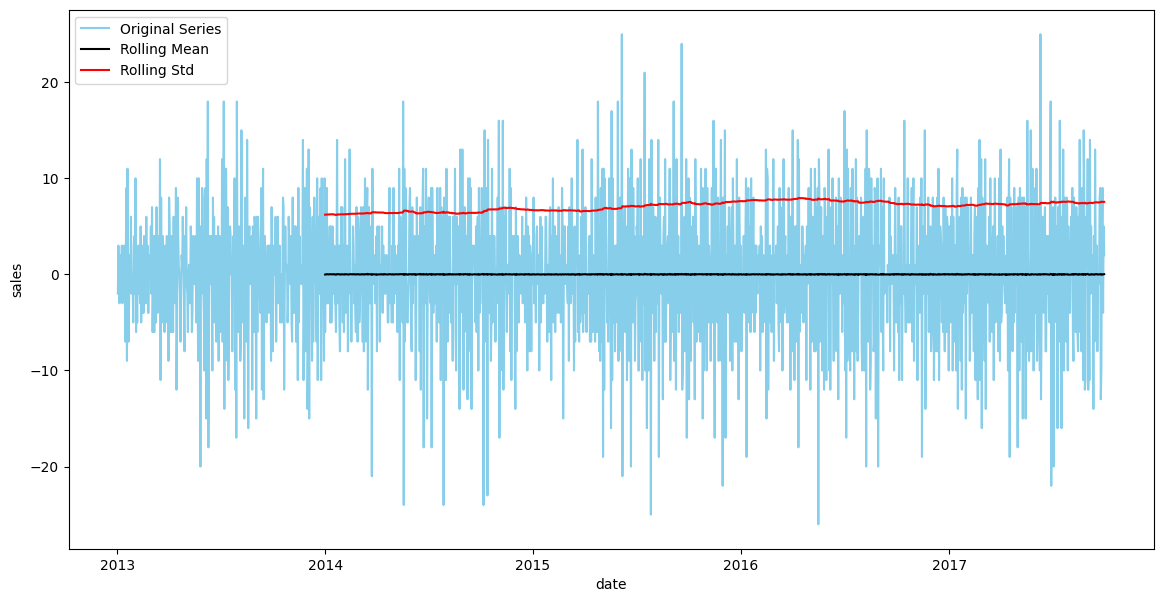



Augmented Dickey-Fuller Test:

Test statistic = -12.326
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


Autocorrelation Plots:


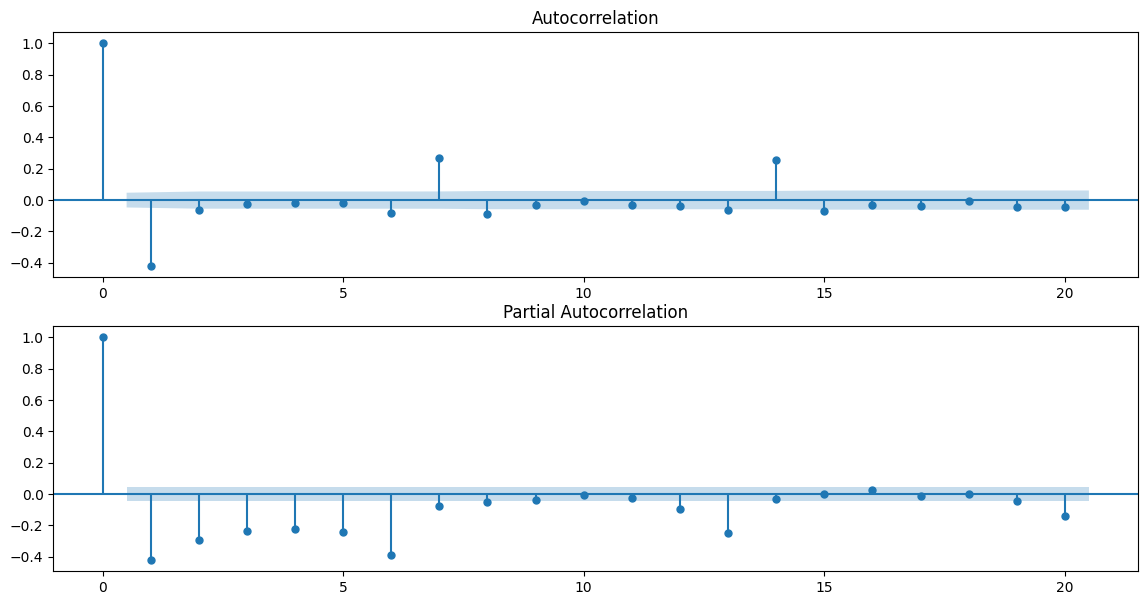

In [19]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

The series is now stationary

#### Applying ARIMA model to the data

(6, 1, 1) is (p, d, q) because 
1. AR(p) = 6 as first 6 lines in PACF are negative
2. I(d) = 1 as 1 order of differencing needed
3. MA(q) = 1 as 1 line is negative in ACF

In [20]:
arima_model61 = ARIMA(arima_df.sales, (6,1,1)).fit(disp=False)
print(arima_model61.summary())

/mnt/c/Users/anand/My Files/NITT/Sem6/DWDM/product-sales-forecasting-master/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/mnt/c/Users/anand/My Files/NITT/Sem6/DWDM/product-sales-forecasting-master/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1733
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5306.599
Method:                       css-mle   S.D. of innovations              5.168
Date:                Thu, 06 May 2021   AIC                          10631.197
Time:                        12:32:19   BIC                          10680.316
Sample:                    01-02-2013   HQIC                         10649.364
                         - 09-30-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0072      0.023      0.314      0.754      -0.038       0.052
ar.L1.D.sales    -0.6038      0.063     -9.658      0.000      -0.726      -0.481
ar.L2.D.sales    -0.6031      0.050    -

#### Plotting Residuals to Check For Seasonality

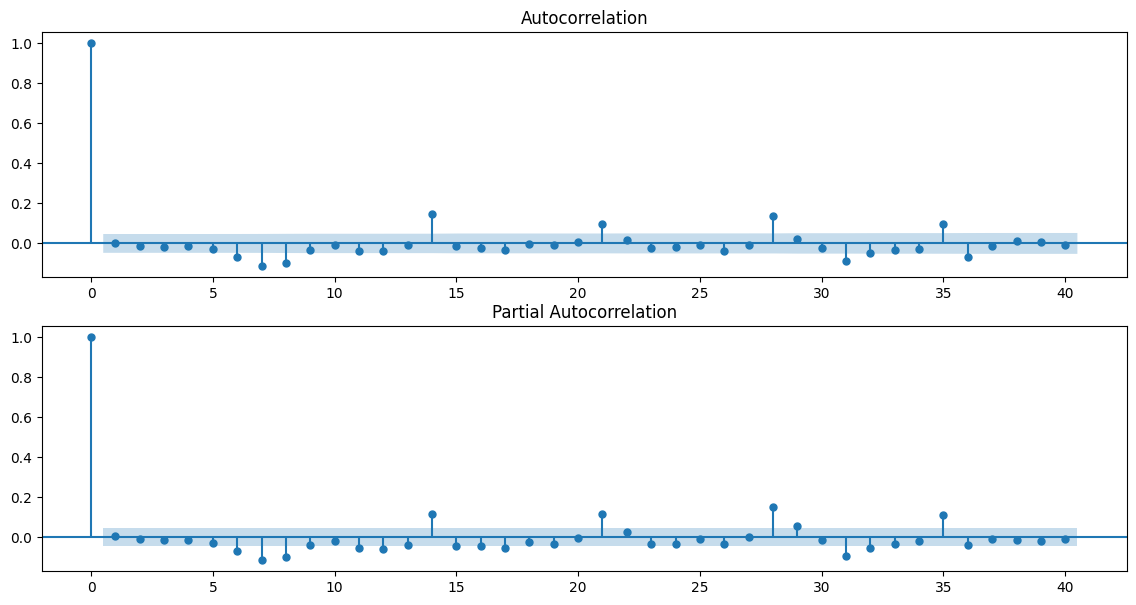

In [21]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

Since ACF and PACF graphs of residuals are similar, seasonality is present.

Hence we have to apply seasonal ARIMA model

/mnt/c/Users/anand/My Files/NITT/Sem6/DWDM/product-sales-forecasting-master/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/mnt/c/Users/anand/My Files/NITT/Sem6/DWDM/product-sales-forecasting-master/myenv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


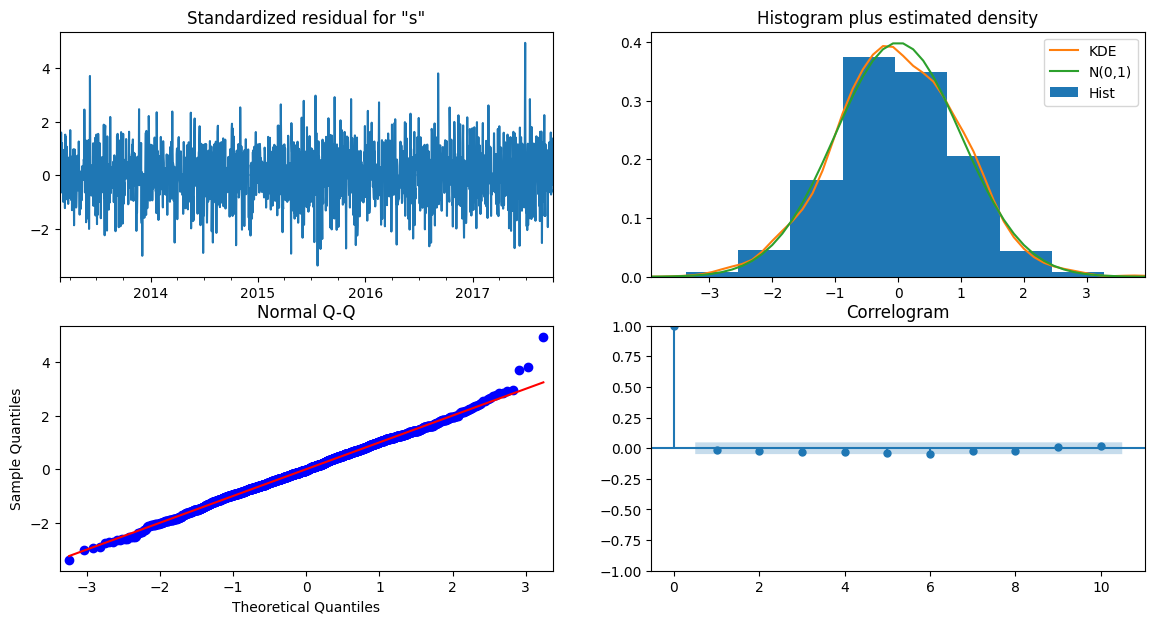

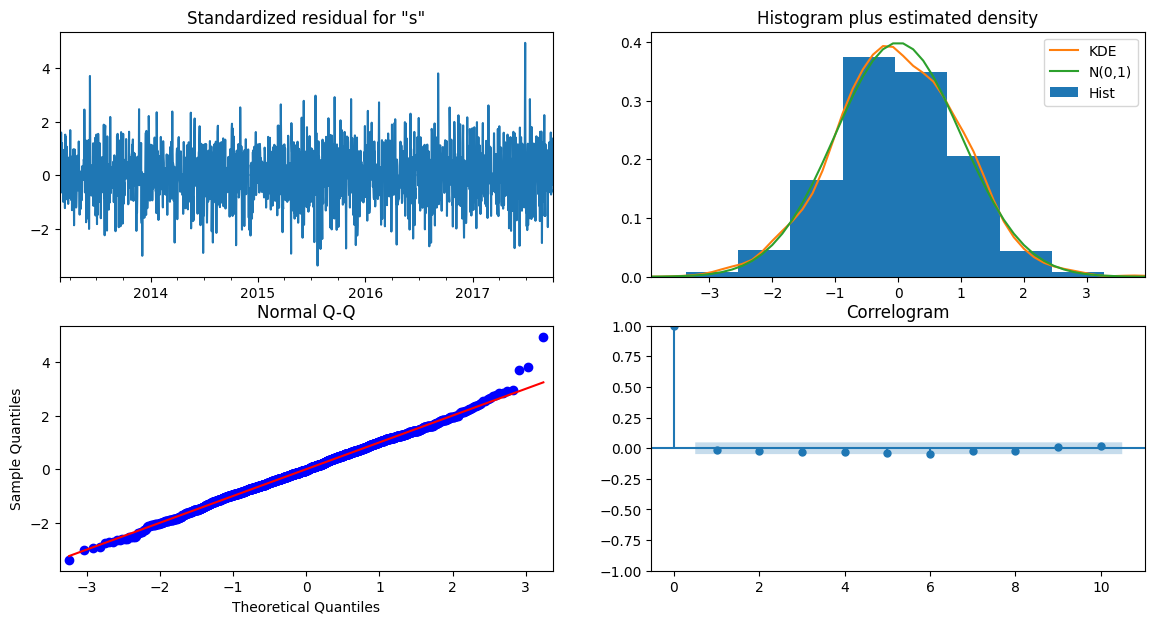

In [22]:
# fit the model
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

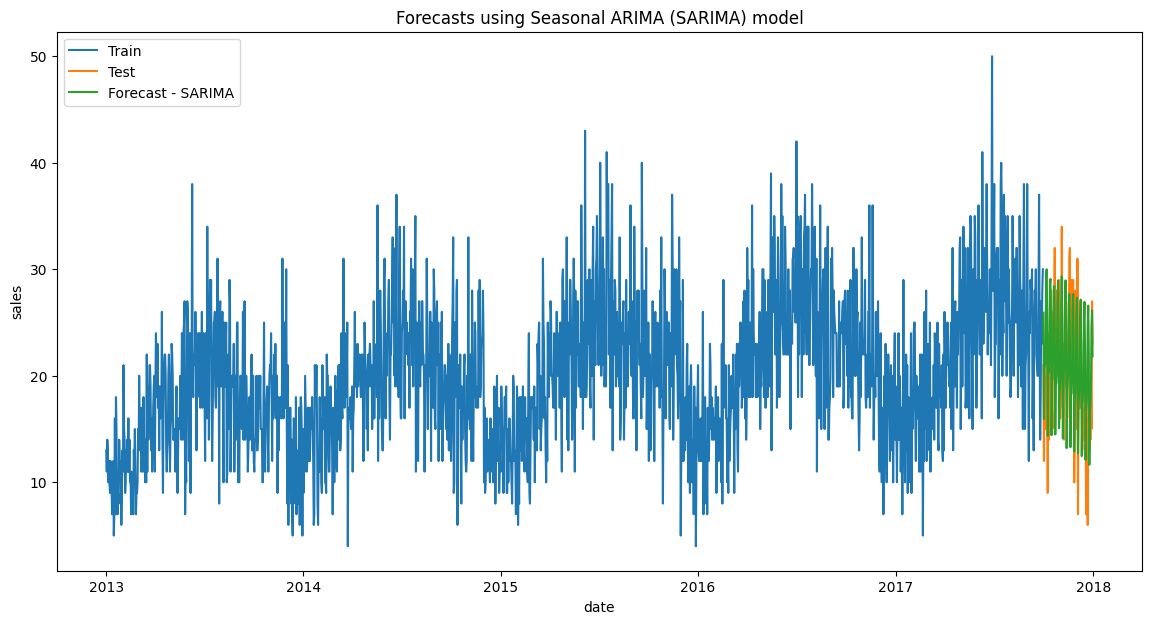

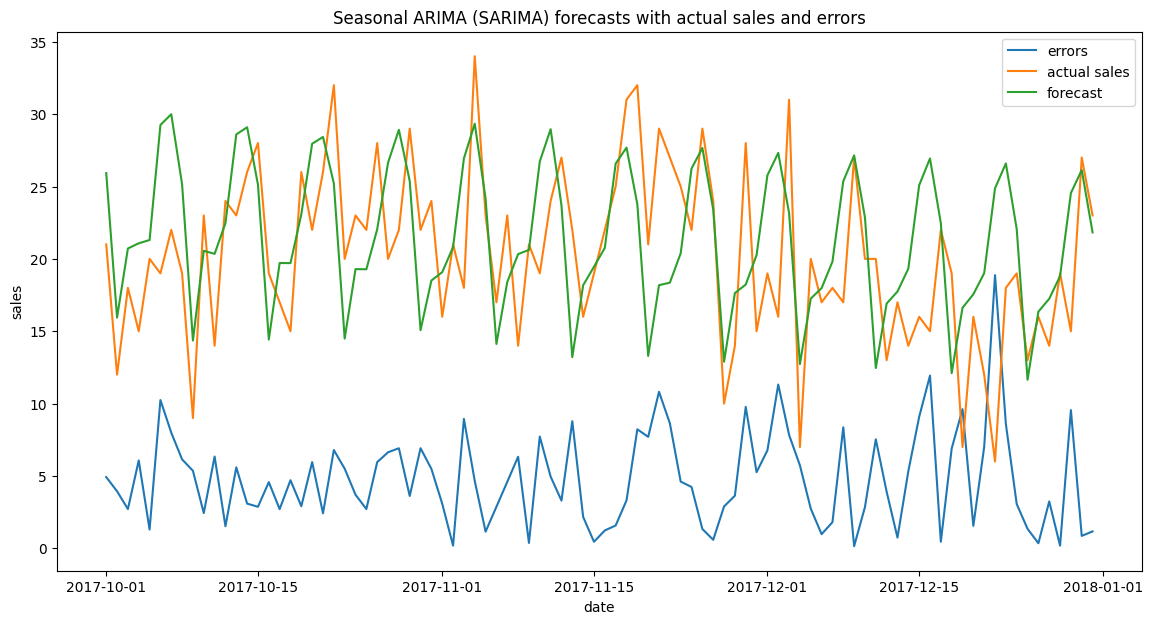

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,1861,1973.19747,-112.19747,4.799933,5.839147,23.728847


In [23]:
# eval
arima_test_df['errors'] = arima_test_df.sales - arima_test_df.pred_sales
arima_test_df.insert(0, 'model', 'SARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_sarima

#### SARIMA Model Results

It has a <b>Mean Absolute Percentage Error of 23.73%</b> which is better than both Seasonal Naive and Holt Winters

### 4. Linear Regression (Suprvised Machine Learning)


In [24]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5
...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,2
1822,2017-12-28,1,1,19,2017,12,28,3
1823,2017-12-29,1,1,15,2017,12,29,4
1824,2017-12-30,1,1,27,2017,12,30,5


In [25]:
# use lag and rolling window feature here
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)
    
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-09-30']                        
reg_test_df = reg_df.loc['2017-10-01':]

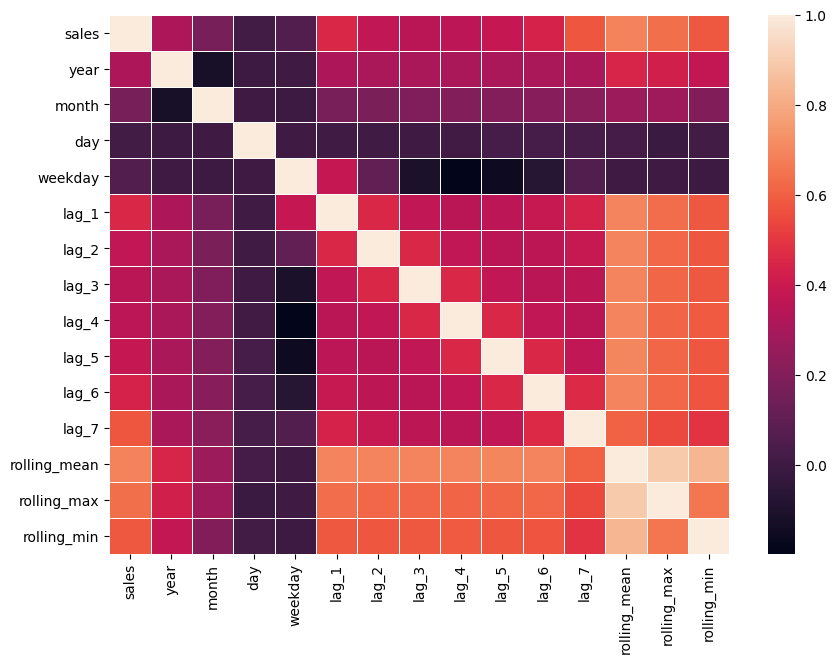

In [26]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [27]:
# Univariate SelectKBest class to extract top 5 best features and then concat
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
11  rolling_mean  1577.946956
12   rolling_max  1170.464035
13   rolling_min   888.451268
10         lag_7   860.565955
4          lag_1   449.743115


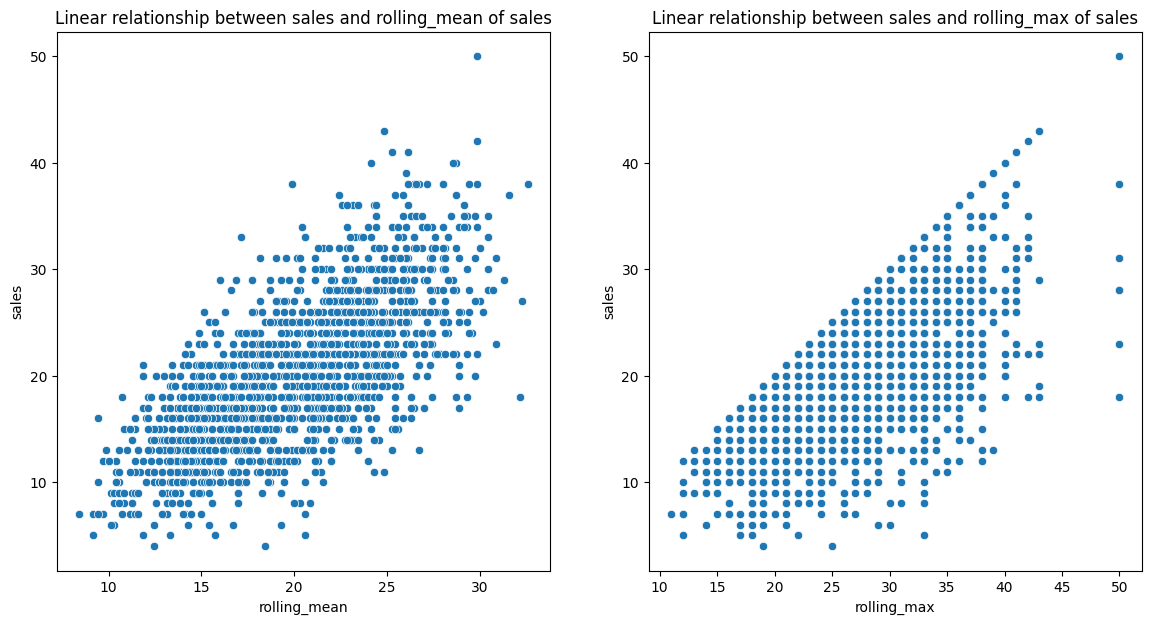

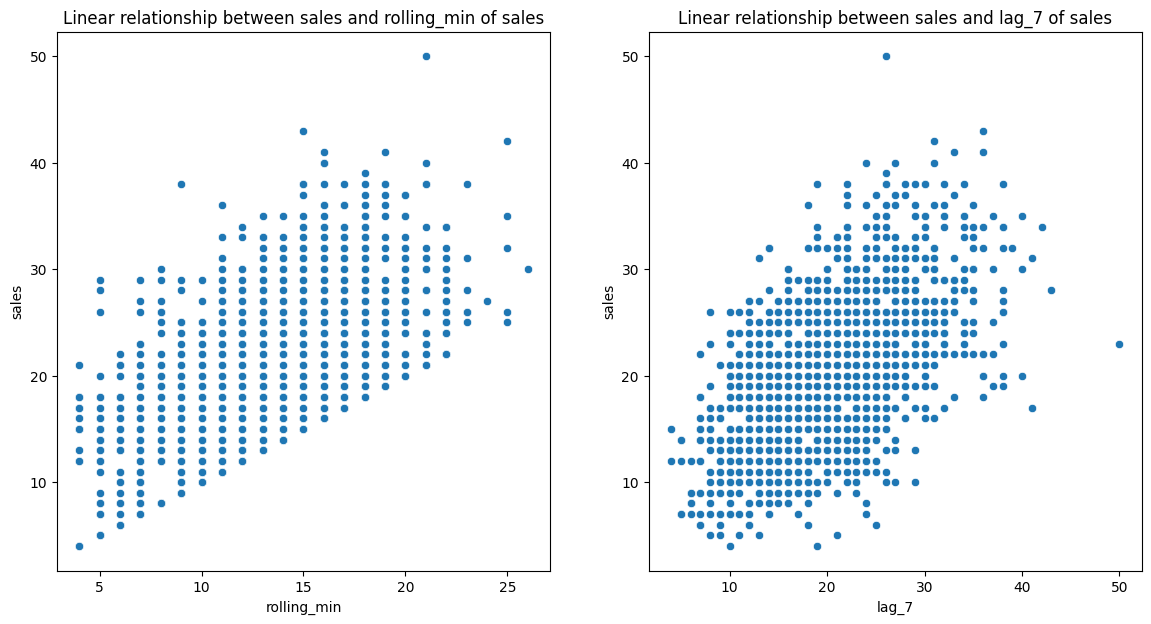

In [28]:
# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_mean, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(reg_train_df.rolling_max, reg_train_df.sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(reg_train_df.rolling_min, reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(reg_train_df.lag_7, reg_train_df.sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [29]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

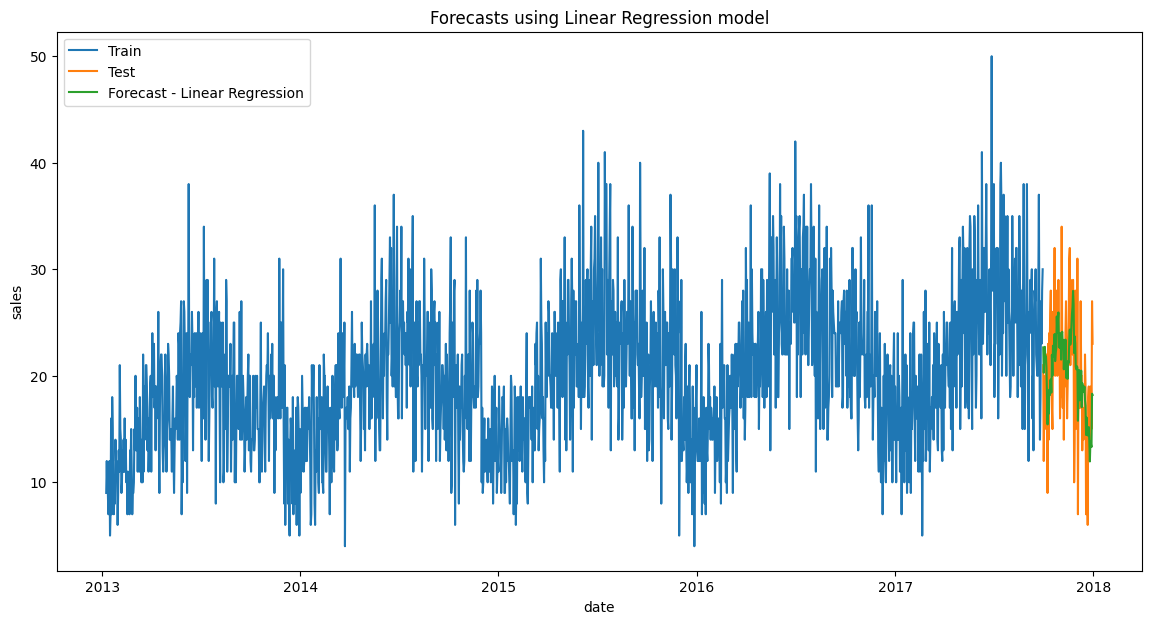

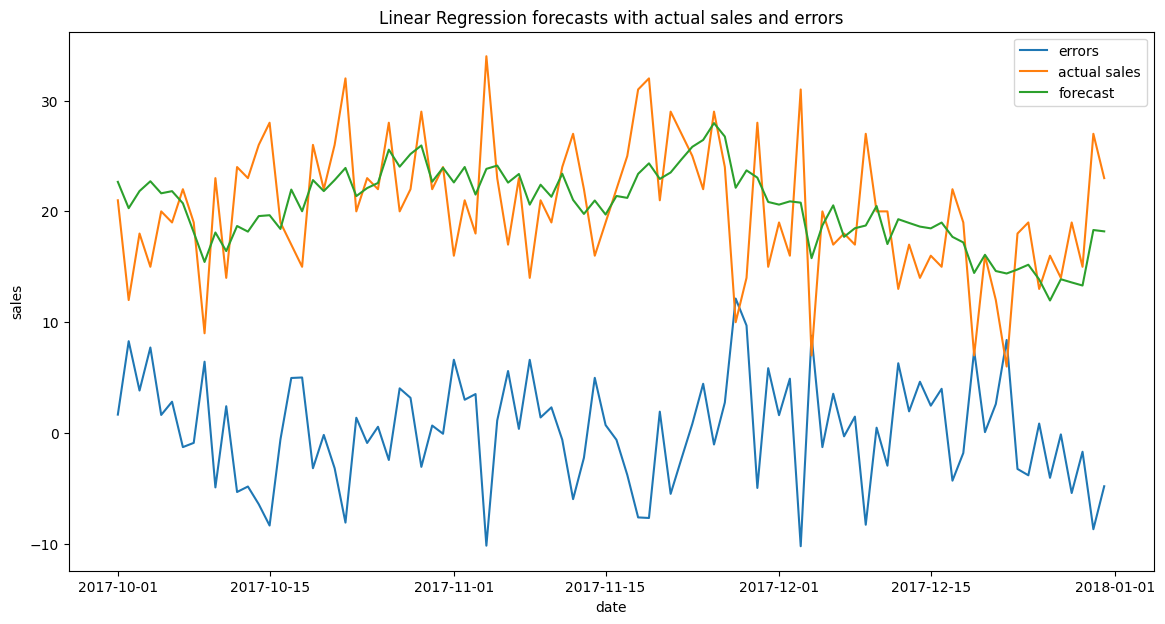

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1861,1882.074831,21.074831,3.858646,4.786183,19.075519


In [30]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr

#### Linear Regression Result

It has a <b> MAPE of 19.08% </b> which is the best of the four models

#### Conclusion

Out of the four models, Linear Regression proved to be more useful than Time Series models.

This is because of the clear seasonality of the sales data.

In such a scenario, regression would be easier to analyse trends